# PyPortrait: Simulating Bokeh with Python

In photography, [bokeh](https://en.wikipedia.org/wiki/Bokeh) is the aesthetic quality of the blur produced in the out-of-focus parts of an image produced by a lens. Bokeh has been defined as "the way the lens renders out-of-focus points of light".

IPhone 7 plus has an additional camera that produces this effect. But its  portrait camera's mode enhances via software with incredible results.

![](img/bokeh-emulation-wikipedia.PNG)
Comparison of bokeh (synthetic) and Gaussian blur - BenFrantzDale Wikipedia CC BY-SA 3.0

(300, 451, 3)

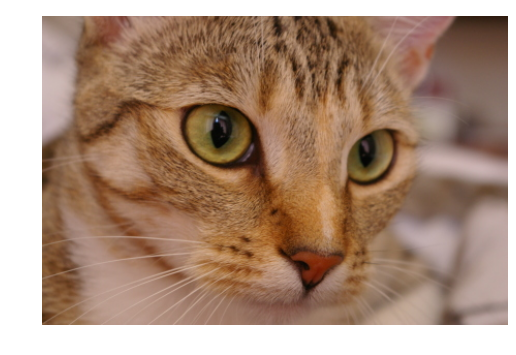

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from skimage import data

%matplotlib inline

cat = data.chelsea()

plt.imshow(cat)
plt.axis('off')

cat.shape # cat is a 300-by-451 pixel image with three channels (red, green, and blue)

That's a nice kitty picture! Notice the out-of-the-focus background (bo-keh!!).The first thing we are going to do is to remove complexity converting the image to black and white. There are different [ways to do that](http://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/), but let's use the one by default in scikit-image that [preserves luminosity](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2gray)

(300, 451)

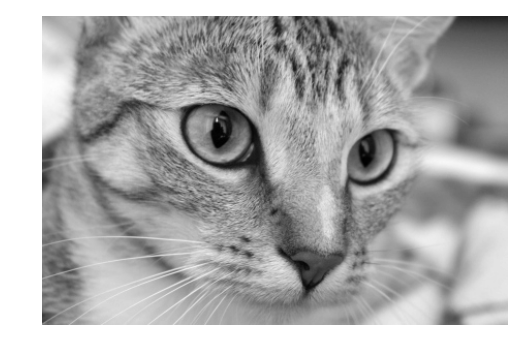

In [2]:
from skimage.color import rgb2gray

cat_gray = rgb2gray(cat)

plt.imshow(cat_gray, cmap=plt.cm.gray)
plt.axis('off')

cat_gray.shape 

Alright! Now we are ready to detect the sharpness of the picture calculating the gradient of the image:

C:\Users\SERVER\Miniconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


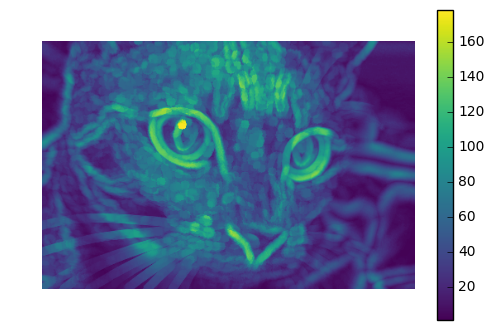

In [3]:
#https://github.com/scikit-image/scikit-image/blob/master/skimage/filters/rank/generic.py#L279

from skimage.morphology import disk
from skimage.filters.rank import gradient, gradient_percentile

selection_element = disk(5) # matrix of n pixels with a disk shape

cat_sharpness = gradient(cat_gray, selection_element)

plt.imshow(cat_sharpness, cmap="viridis")
plt.axis('off')
plt.colorbar()

plt.show()

That's cool, now whe have a quantitative number that measures the sharpness. So if we compute the gradient selecting more pixels we might obtain a scalable non-detail map where we can apply more blur (bokeh!)

C:\Users\SERVER\Miniconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


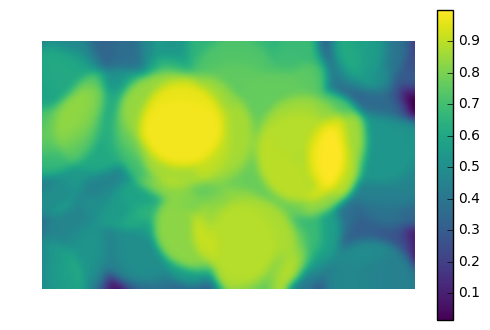

In [4]:
from skimage.filters import gaussian

selection_element = disk(50) # matrix of n pixels with a disk shape

cat_sharpness = gradient(cat_gray, selection_element)

cat_sharpness_std = (cat_sharpness - cat_sharpness.min())/(cat_sharpness.max()-cat_sharpness.min())

# (optional) Removes sharp edges of disk
cat_sharpness_std = gaussian(cat_sharpness_std, sigma=5)

plt.imshow(cat_sharpness_std, cmap="viridis")
plt.axis('off')
plt.colorbar()

plt.show()

And here is the _grand finale_. Let's apply a [gaussian blur filter](http://scikit-image.org/docs/0.12.x/api/skimage.filters.html#skimage.filters.gaussian) and a mean blur filter using a disk as a kernel the different effects we can get. Notice that we will use 'cat_sharpness_std' as linear mask to blur only the background:

C:\Users\SERVER\Miniconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


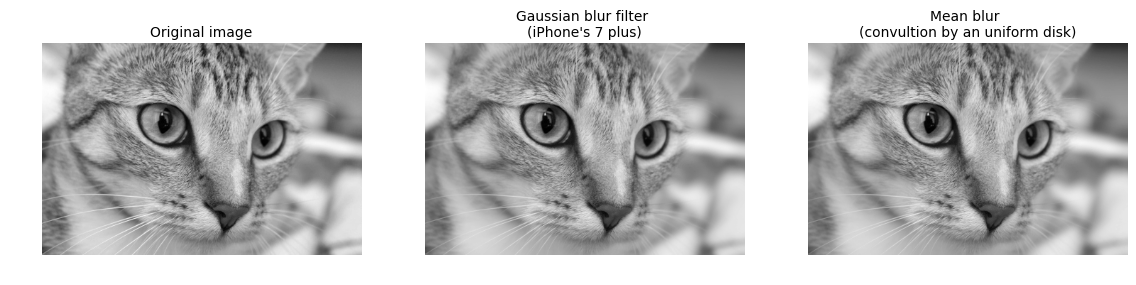

In [17]:
from skimage.filters import gaussian
from skimage.filters.rank import mean
from skimage.morphology import disk

from skimage import img_as_float


# Gaussian blur filter (as the iPhones 7 plus)
cat_gray_gauss = gaussian(cat_gray, sigma=5)

cat_gray_gauss_final = cat_gray*cat_sharpness_std + \
                        + cat_gray_gauss*(1-cat_sharpness_std)


# Mean filter (more realistic bokeh!)
selection_element = disk(10) # matrix of n pixels with a disk shape
cat_gray_mean = img_as_float(mean(cat_gray, selection_element))

cat_gray_mean_final = cat_gray*cat_sharpness_std + \
                       + cat_gray_mean*(1-cat_sharpness_std)


# Plotting code
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 10))

axes[0].imshow(cat_gray, cmap=plt.cm.gray)
axes[0].set_title('Original image', fontsize=10)
axes[0].set_axis_off()

axes[1].imshow(cat_gray_gauss_final, cmap=plt.cm.gray)
axes[1].set_title('Gaussian blur filter \n(iPhone\'s 7 plus)', fontsize=10)
axes[1].set_axis_off()

axes[2].imshow(cat_gray_mean_final, cmap=plt.cm.gray)
axes[2].set_title('Mean blur \n(convultion by an uniform disk)', fontsize=10)
axes[2].set_axis_off()

plt.show()

In [23]:
# TODO color version has some problems with brightness

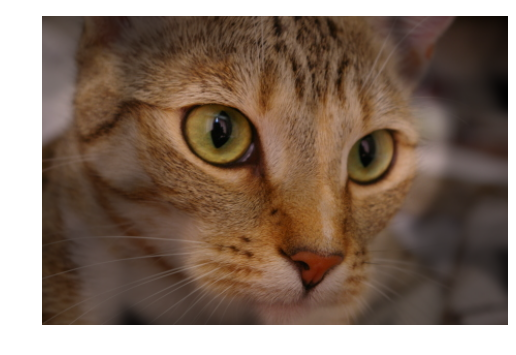

In [24]:
from skimage.filters import gaussian

filtered_cat = gaussian(cat, sigma=10, multichannel=True)

# cat_sharpness_std_color = np.tile(cat_sharpness_std[..., None],[1,1,3])
cat_sharpness_std_color = np.dstack((cat_sharpness_std, ) * 3)

cat_final = np.copy(cat)
cat_final[:,:,0] = cat_sharpness_std*cat[:,:,0] + (1-cat_sharpness_std)*filtered_cat[:,:,0]
cat_final[:,:,1] = cat_sharpness_std*cat[:,:,1] + (1-cat_sharpness_std)*filtered_cat[:,:,1]
cat_final[:,:,2] = cat_sharpness_std*cat[:,:,2] + (1-cat_sharpness_std)*filtered_cat[:,:,2]

# Not working properly
#cat_final = cat*cat_sharpness_std_color + filtered_cat*(1-cat_sharpness_std_color) 

# Not working properly
plt.imshow(cat_final)
plt.axis('off')

plt.show()

Well, to be honest in this image the bokeh in the background is so prominent that we hardly see a difference. Let's create a synthetic image to clarify the difference between gaus and mean blur:

C:\Users\SERVER\Miniconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


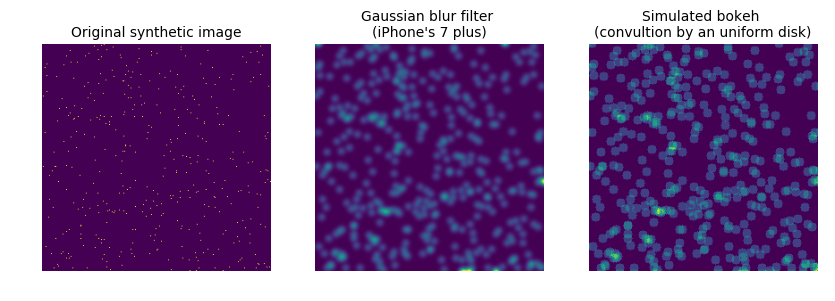

In [21]:
import numpy as np

from skimage.morphology import disk
from skimage.filters.rank import mean
from skimage.filters import gaussian

import matplotlib.pyplot as plt

n = 20
l = 256
im = np.zeros((l, l))
points = l * np.random.random((2, n ** 2))

# Original
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1

# Gaussian filter (as in iPhone's)
im_gauss = gaussian(im, sigma=3) #gauss with a 5 pixels as std

# Mean filter (more realistic bokeh!)
selection_element = disk(5) # matrix of n pixels with a disk shape
im_mean = mean(im, selection_element)

# Plotting code
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

axes[0].imshow(im, cmap=plt.cm.viridis)
axes[0].set_title('Original synthetic image', fontsize=10)
axes[0].set_axis_off()

axes[1].imshow(im_gauss, cmap=plt.cm.viridis)
axes[1].set_title('Gaussian blur filter \n(iPhone\'s 7 plus)', fontsize=10)
axes[1].set_axis_off()

axes[2].imshow(im_mean, cmap=plt.cm.viridis)
axes[2].set_title('Simulated bokeh \n(convultion by an uniform disk)', fontsize=10)
axes[2].set_axis_off()

plt.show()

We can even change the shape of our aperture (element)

C:\Users\SERVER\Miniconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


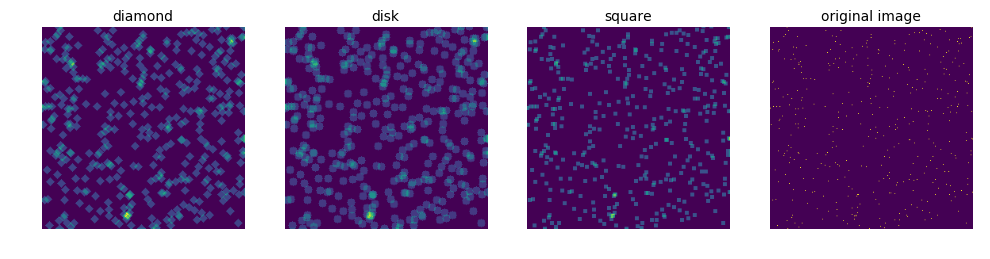

In [22]:
import numpy as np
from skimage.morphology import diamond, disk, square
from skimage.filters.rank import mean, modal

from skimage.filters import gaussian
import matplotlib.pyplot as plt

n = 20
l = 256
im = np.zeros((l, l))
points = l * np.random.random((2, n ** 2))

# Original
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1

# Plotting code
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 10))
axes[3].imshow(im, cmap=plt.cm.viridis)
axes[3].set_title('original image', fontsize=10)
axes[3].set_axis_off()

element_list = [diamond, disk, square]

for i, element in enumerate(element_list):
    selection_element = element(5) # matrix of n pixels with a disk shape
    im_mean = mean(im, selection_element)
    
    axes[i].imshow(im_mean, cmap=plt.cm.viridis)
    axes[i].set_title(element.__name__, fontsize=10)
    axes[i].set_axis_off()

plt.show()

TODO: Take a look to the example with Lenna image.